Assignment: Voter classification using exit poll data
=====================================================

**TODO**: Edit this cell to fill in your NYU Net ID and your name:

-   **Net ID**:
-   **Name**:

In this notebook, we will explore the problem of voter classification.

Given demographic data about a voter and their opinions on certain key
issues, can we predict their vote in the 2016 U.S. presidential
election? We will attempt this using a K nearest neighbor classifier.

In the first part of this notebook, I will show you how to train and use
a K nearest neighbors classifier for this task. In the next part of the
notebook, you will try to improve the basic model for better
performance.

Import libraries
----------------

In [ ]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import ShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import nan_euclidean_distances

We will need to install a library that is not in the default Colab
environment, which we can install with `pip`:

In [ ]:
!pip install category_encoders

In [ ]:
import category_encoders as ce

Load data
---------

The data for this notebook comes from the [U.S. National Election Day
Exit
Polls](https://ropercenter.cornell.edu/exit-polls/us-national-election-day-exit-polls).

Here's a brief description of how exit polls work.

Exit polls are conducted by Edison Research on behalf of a consortium of
media organizations.

First, the member organizations decide what races to cover, what sample
size they want, what questions should be asks, and other details. Then,
sample precincts are selected, and local interviewers are hired and
trained. Then, at those precincts, the local interviewer approaches a
subset of voters as they exit the polls (for example, every third voter,
or every fifth voter, depending on the required sample size).

When a voter is approached, they are asked if they are willing to fill
out a questionnaire. Typically about 40-50% agree. (For those that
decline, the interviewer visually estimates their age, race, and gender,
and notes this information, so that the response rate by demographic is
known and responses can be weighted accordingly in order to be more
representative of the population.)

Voters that agree to participate are then given an form with 15-20
questions. They fill in the form (anonymously), fold it, and put it in a
small ballot box.

Three times during the day, the interviewers will stop, take the
questionnaires, compile the results, and call them in to the Edison
Research phone center. The results are reported immediately to the media
organizations that are consortium members.

In addition to the poll of in-person voters, absentee and early voters
(who are not at the polls on Election Day) are surveyed by telephone.

The exit poll data is not freely available on the web, but is available
to those with institutional membership. You will be able to use your NYU
email address to create an account with which you can download the exit
poll data.

To get the data, visit [the Roper Center
website](https://persistent.library.nyu.edu/arch/NYU02495). Click on the
user icon in the top right of the page, and choose “Log in”.

For “Your Affiliation”, choose “New York University”.

Then, choose “Register” (highlighted in yellow below).

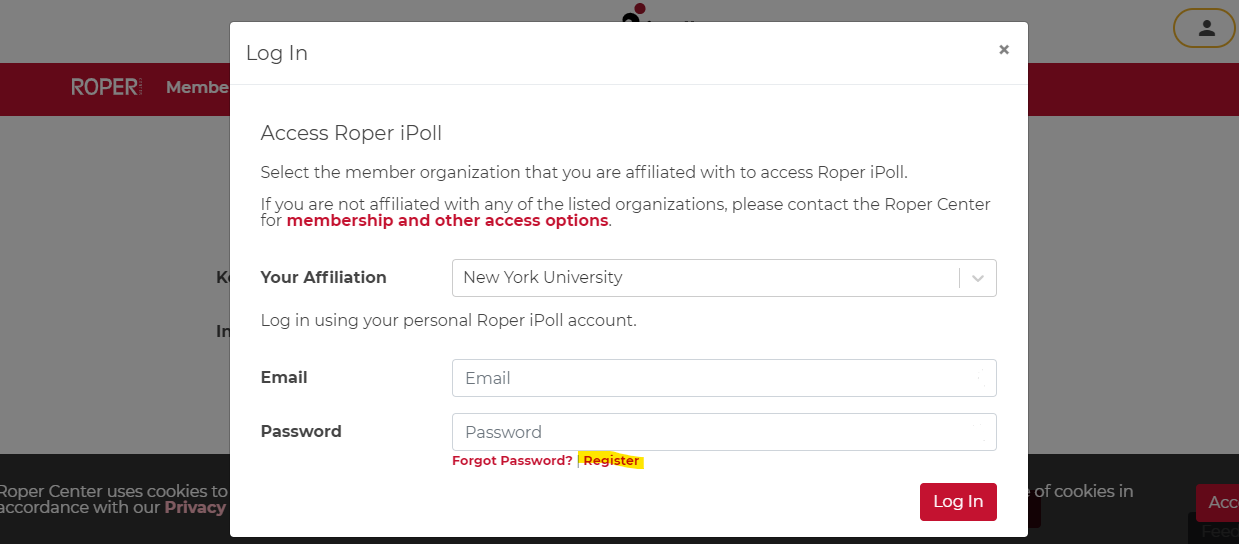

Enter your NYU email address (highlighted in yellow below) and then
click “Register”.

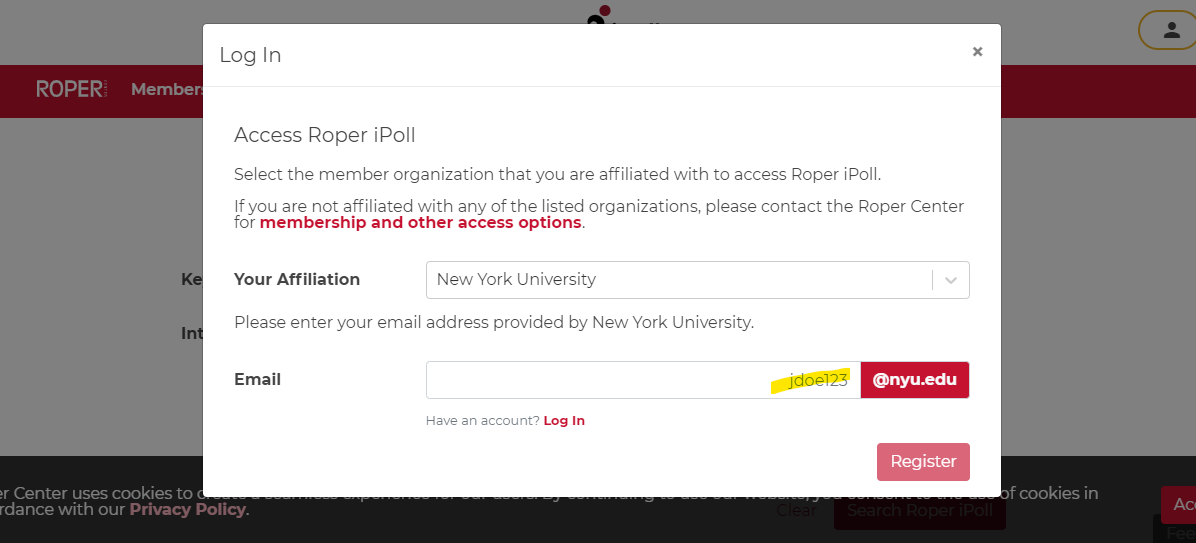

You will get an email at your NYU email address with the subject “Roper
iPoll Account Registration”. Open the email and click “Confirm Account”
to create a password and finish your account registration.

Once you have completed your account registration, log in to Roper iPoll
by clicking the user icon in the top right of the page, choosing “Log
in”, and entering your NYU email address and password.

Then, open the Study Record for the [2016 National Election Day Exit
Poll](https://ropercenter.cornell.edu/ipoll/study/31116396).

Click on the “Downloads” tab, and then click on the CSV data file
(highlighted in the image below).

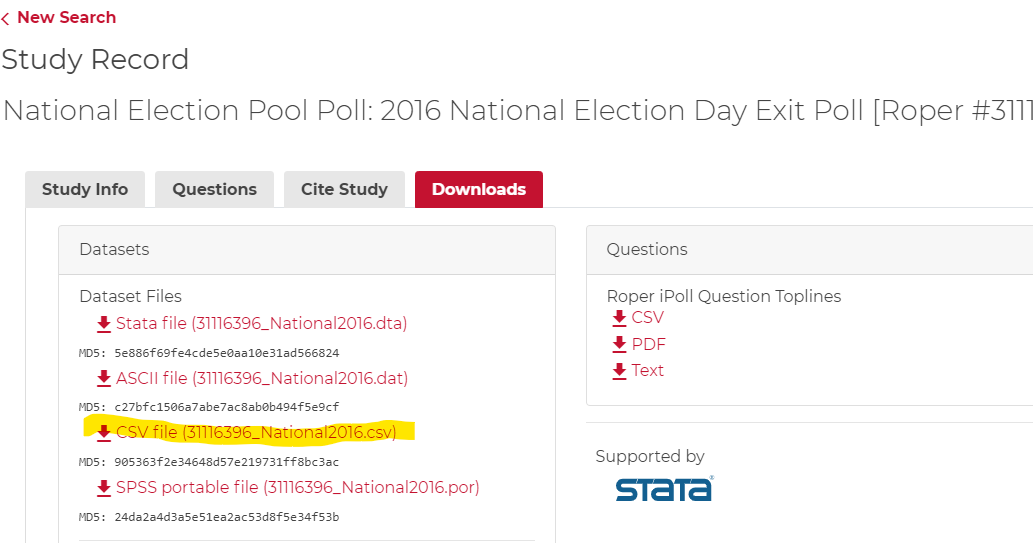

Accept the terms (click “Accept terms”) and the file will be downloaded
to your computer.

After you download the CSV file, scroll down a bit until you see the
“Study Documentation, Questionnaire and Codebooks” PDF file. Download
this file as well.

To get the data into Colab, run the following cell. Upload the CSV file
you just downloaded (`31116396_National2016.csv`) to your Colab
workspace. Wait until the uploaded has **completely** finished - it may
take a while, depending on the quality of your network connection.

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Then, use the `read_csv` function in `pandas` to read in the file.

Also use `head` to view the first few rows of data and make sure that
everything is read in correctly.

In [ ]:
df = pd.read_csv('31116396_National2016.csv')
df.head()

Prepare data
------------

Survey data can be tricky to work with, because surveys often “branch”;
the questions that are asked depends on a respondent’s answers to other
questions.

In this case, different respondents fill out different versions of the
survey.

Review pages 7-11 of the “Study Documentation, Questionnaire, and
Codebooks” PDF file you downloaded earlier, which shows the five
different questionnaire versions used for the 2016 exit polls.

![Exit poll
versions](https://raw.githubusercontent.com/ffund/ml-notebooks/master/notebooks/images/exit-poll-survey-versions.png)

In [ ]:
df['VERSION'].value_counts()

In a red box next to each question, you can also see the name of the
variable (column name) that the respondent’s answer will be stored in.

Because each respondent answers different questions, for each row in the
data, only some of the columns - the columns corresponding to questions
included in that version of the survey - have data.

### Missing data

Since each respondent only saw a subset of questions, we expect to see
missing values in each column.

However, if we look at the **count** of values in each column, we see
that there are no missing values - every column has the full count!

In [ ]:
df.describe(include='all')

This is because missing values are recorded as a single space, and not
with a NaN.

Let’s change that:

In [ ]:
df.replace(" ", float("NaN"), inplace=True)

Now we can see an accurate count of the number of responses in each
column:

In [ ]:
df.describe(include='all')

Notice that *every* row has some missing data! So, we can’t just remove
rows with missing data and work with the complete data.

Instead, we’l have to make sure that the classifier we use is able to
work with partial data. One important benefit of K nearest neighbors is
that it can work well with data that has missing values, as long as we
can think of a distance metric that behaves reasonably under these
conditions.

### Encode target variable as a binary variable

Our goal is to classify voters based on their vote in the 2016
presidential election, i.e. the value of the `PRES` column. We will
restrict our attention to the candidates from the two major parties, so
we will throw out the rows representing voters who chose other
candidates:

In [ ]:
df = df[df['PRES'].isin(['Donald Trump', 'Hillary Clinton'])]
df.reset_index(inplace=True, drop=True)
df.info()

In [ ]:
df.head()

In [ ]:
df['PRES'].value_counts()

Now, we will transform the string value into a binary variable, and save
the result in `y`.

In [ ]:
y = df['PRES'].map({'Donald Trump': 1, 'Hillary Clinton': 0}) 
y.value_counts()

### Get training and test indices

We’l be working with many different subsets of this dataset, including
different columns.

So instead of splitting up the data into training and test sets, we’l
get an array of training indices and an array of test indices using
`ShuffleSplit`. Then, we can use these arrays throughout this notebook.

In [ ]:
idx_tr, idx_ts = next(ShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 3).split(df['PRES']))

I specified the state of the random number generator for repeatability,
so that every time we run this notebook we’l have the same split. This
makes it easier to discuss specific examples.

Now, we can use the `pandas` function `.iloc` to get the training and
test parts of the data set for any column.

For example, if we want the training subset of `y`:

In [ ]:
y.iloc[idx_tr]

or the test subset of `y`:

In [ ]:
y.iloc[idx_ts]

### Encode ordinal features

Next, we need to encode our features. All of the features are
represented as strings, but we will have to transform them into
something over which we can compute a meaningful distance measure.

Columns that have a logical order should be encoded using ordinal
encoding, so that the distance metric will be meaningful.

For example, consider the `AGE` column:

In [ ]:
df['AGE'].unique()

In [ ]:
df['AGE'].value_counts()

What if we transform the `AGE` column using four binary columns:
`AGE_18-29`, `AGE_30-44`, `AGE_45-65`, `AGE_65+`, with a 0 or a 1 in
each column to indicate the respondent’s age?

If we did this, we would lose meaningful information about the distance
between ages; a respondent whose age is 18-29 would have the same
distance to one whose age is 45-65 as to one whose age is 65+.

Instead, we will use ordinal encoding, which will represent `AGE` in a
single column with *ordered* integer values.

First, we create an `OrdinalEncoder`:

In [ ]:
enc_ord = ce.OrdinalEncoder(handle_missing='return_nan')

Then, we `fit` it by passing the columns that we wish to encode as
ordinal values:

In [ ]:
enc_ord.fit(df['AGE'])

Finally, we use the “fitted” encoder to `transform` the data, and we
save the result in `df_enc_ord`.

In [ ]:
df_enc_ord = enc_ord.transform(df['AGE'])
df_enc_ord['AGE'].value_counts()

We can pass more than one feature to our encoder, and it will encode all
features. For example, let us consider the column `EDUC12R`, which
includes the respondent’s answer to the question:

> Which best describes your education?
>
> 1.  High school or less
> 2.  Some college/assoc. degree
> 3.  College graduate
> 4.  Postgraduate study

In [ ]:
df['EDUC12R'].value_counts()

We can try to fit the encoder using both `AGE` and `EDUC12R`:

In [ ]:
features = ['EDUC12R', 'AGE']

enc_ord = ce.OrdinalEncoder(handle_missing='return_nan')
enc_ord.fit(df[features])

For this column, the order that the encoder “guesses” is not the desired
order - the “High school or less” answer should have the smallest value,
followed by “Some college/assoc. degree”, then “College graduate”, then
“Postgraduate study”.

To address this, we will pass a dictionary that tells the encoder
exactly how to map these columns so that they are in the desired order:

In [ ]:
mapping_dict = {'col': 'AGE', 'mapping': 
                {'18-29': 1, 
                 '30-44': 2,
                 '45-65': 3,
                 '65+': 4}
                }, {'col': 'EDUC12R', 'mapping':  
                  {'High school or less': 1,
                   'Some college/assoc. degree': 2,
                   'College graduate': 3,
                   'Postgraduate study': 4}
                    }

features = ['EDUC12R', 'AGE']

enc_ord = ce.OrdinalEncoder(handle_missing='return_nan', mapping=mapping_dict)
enc_ord.fit(df[features])

(Note: for certain features, some rows may have an “Omit” value. These
should be mapped to -1, which we will convert to NaN later.)

Then, we can get the encoded version of these columns:

In [ ]:
df_enc_ord = enc_ord.transform(df[features])

In [ ]:
df_enc_ord['AGE'].value_counts()

In [ ]:
df_enc_ord['EDUC12R'].value_counts()

Missing values were encoded as -1, which we can transform back to NaN:

In [ ]:
df_enc_ord.replace(-1, float("NaN"), inplace=True)
df_enc_ord.isna().sum()

Note that the values in the encoded columns range from 1 to the number
of categories.

For K nearest neighbors, the “importance” of each feature in determining
the class label would be proportional to its scale. If we leave it as
is, any feature with a larger range of possible values will be
considered more “important!”

So, we will re-scale our encoded features to the unit interval:

In [ ]:
for col in df_enc_ord.columns:
  df_enc_ord[col] = df_enc_ord[col]-df_enc_ord[col].min(skipna=True)
  df_enc_ord[col] = df_enc_ord[col]/df_enc_ord[col].max(skipna=True)

In [ ]:
df_enc_ord.describe()

Now, each feature is on the same scale - the value varies 0 to 1.

### Encode categorical features

In the previous section, we encoded features that have a logical
ordering.

Other categorical features, such as `RACE`, have no logical ordering.

In [ ]:
df['RACE'].value_counts()

These should be encoded using one-hot encoding, which will create a new
column for each unique value, and then put a 1 or 0 in each column to
indicate the respondent’s answer.

In [ ]:
enc_oh = ce.OneHotEncoder(use_cat_names=True, handle_missing='return_nan')
enc_oh.fit(df['RACE'])

In [ ]:
df_enc_oh = enc_oh.transform(df['RACE'])

In [ ]:
df_enc_oh

Note that we have some respondents for which this feature is not
available. These respondents have a NaN in all `RACE` columns:

In [ ]:
df_enc_oh.isnull().sum()

So, we can drop the `RACE_nan` column.

(For certain columns, some rows may have an “Omit” value recorded. We
would also drop `FEATURE_Omit` columns wherever they may occur, so that
these will not be included in the distance computations.)

In [ ]:
columns_to_drop = ['RACE_nan']
df_enc_oh.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
df_enc_oh.head()

Train a k nearest neighbors classifier
--------------------------------------

Now that we have a target variable, a couple of features, and training
and test indices, let’s see what happens if we try to train a K nearest
neighbors classifier.

First, we’l prepare our feature data, by column-wise concatenating the
ordinal-encoded feature columns and the one-hot-encoded feature columns:

In [ ]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

Here are the summary statistics for the training data:

In [ ]:
X.iloc[idx_tr].describe()

and for the test data:

In [ ]:
X.iloc[idx_ts].describe()

This classifier will only use a few features, but we’l see how well we
can do with those to start.

### Baseline: “prediction by mode”

As a baseline against which to judge the performance of our classifier,
let’s find out the accuracy of a classifier that gives the majority
class label (0) to all samples in our test set:

In [ ]:
accuracy_score(y.iloc[idx_ts], np.repeat(0, len(y.iloc[idx_ts])))

A classifier trained on the data should do *at least* as well as the one
that predicts the majority class label. Hopefully, we’l be able to do
much better!

### `KNeighborsClassifier` does not support data with NaNs

If we try to train a `KNeighborsClassifier` on our data using the
default settings, it will fail with the error message

    ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

Un-comment these lines, run the cell, and see for yourself:

In [ ]:
#clf = KNeighborsClassifier(n_neighbors=3)
#clf.fit(X.iloc[idx_tr], y.iloc[idx_tr])

This is because we have many missing values in our data:

In [ ]:
X.isna().sum()

The distance metric is not defined for vectors with missing values.

### Writing our own `KNeighborsClassifier`

Although we cannot use the `sklearn` implementation of a
`KNeighborsClassifier`, we can write our own. We need a few things:

-   a function that implements a distance metric
-   a function that accepts a distance matrix and returns the indices of
    the K smallest values for each row
-   a function that returns the majority vote of the training samples
    represented by those indices

Let’s start with the distance metric. Suppose we use an L1 distance
computed over the features that are non-NaN for both samples:

In [ ]:
def custom_distance(a, b):
  dif = np.abs(np.subtract(a,b))    # element-wise absolute difference
  # dif will have NaN for each element where either a or b is NaN
  l1 = np.nansum(dif, axis=1)  # sum of differences, treating NaN as 0
  return l1

The function above expects a vector for the first argument and a matrix
for the second argument, and returns a vector.

For example: suppose you pass a test point $x_t$ and a matrix of
training samples where each row $x_0, \ldots, x_n$ is another training
sample. It will return a vector $d_t$ with as many elements as there are
training samples, and where the $i$th entry is the distance between the
test point $x_t$ and training sample $x_i$.

To see how to this function is used, let’s consider an example with a
small number of test samples and training samples.

Suppose we had this set of test data:

In [ ]:
a_idx = np.array([10296, 510,4827,20937, 22501])
a = X.iloc[a_idx]
a

and this set of training data:

In [ ]:
b_idx = np.array([10379, 4343, 7359,  1028,  2266, 131, 11833, 14106,  6682,  4402, 11899,  5877, 11758, 13163])
b = X.iloc[b_idx]
b

We will set up a *distance matrix* in which to store the results. In the
distance matrix, an entry in row $i$, column $j$ represents the distance
between row $i$ of the test set and row $j$ of the training set.

So the distance matrix should have as many rows as there are test
samples, and as many columns as there are training samples.

In [ ]:
distances_custom = np.zeros(shape=(len(a_idx), len(b_idx)))
distances_custom.shape

Instead of a conventional `for` loop, we will use a
[tqdm](https://github.com/tqdm/tqdm) `for` loop. This library
conveniently “wraps” the conventional `for` loop with a progress part,
so we can see our progress while the loop is running.

In [ ]:
# the first argument to tqdm, range(len(a_idx)), is the list we are looping over
for idx in tqdm(range(len(a_idx)),  total=len(a_idx), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X.iloc[a_idx[idx]], X.iloc[b_idx])

In [ ]:
np.set_printoptions(precision=2) # show at most 2 decimal places
print(distances_custom)

Now, for each test sample, we can:

-   get an array of indices from the *distance matrix*, sorted in order
    of increasing distance
-   get the list of the K nearest neighbors as the first K elements from
    that list,
-   and then from those entries - which are indices with respect to the
    distance matrix - get the corresponding indices in `X`:

In [ ]:
k = 3
distances_sorted = np.array([np.argsort(row) for row in distances_custom])
nn_lists = distances_sorted[:, :k]
nn_lists_idx = b_idx[nn_lists]

For example, here was the first test sample:

In [ ]:
X.iloc[[10296]]

and here are its closest neighbors among the training samples:

In [ ]:
X.iloc[nn_lists_idx[0]]

their corresponding values in `y`:

In [ ]:
y.iloc[nn_lists_idx[0]]

and their distances:

In [ ]:
distances_custom[0, nn_lists[0]]

and so the predicted vote for the first test sample would be:

In [ ]:
y.iloc[nn_lists_idx[0]].mode()

You may have noticed a problem: training sample 10379, which has all NaN
values, has zero distance to *every* test sample according to our
distance function. (Note that the first column in the distance matrix,
corresponding to the first training sample, is all zeros.)

This means that this sample will be a “nearest neighbor” of *every* test
sample! But, it’s not necessarily similar to those other test samples.
We just *don’t have any information* by which to judge how similar it is
to other samples.

The case with an all-NaN training sample is a bit extreme, but it
illustrates how our simple distance metric is problematic in other
situations as well:

-   If a sample has only NaN values for the features we decide to
    include, its distance to every other sample is 0 and it will be
    considered a “nearest neighbor” to everyone.
-   If two samples have no non-NaN features in common - for example, if
    sample $a$ is NaN for every feature where sample $b$ is non-NaN -
    the distance between them will be 0, and they will be considered
    very similar, even though we just don’t have any information by
    which to judge how similar they are.
-   Even for samples that have non-NaN features in common, our distance
    metric is problematic because it doesn’t care how much the two
    samples have in common - only how many features they disagree on.

For example, consider these two samples from the original data:

In [ ]:
pd.set_option('display.max_columns', 150)
disp_features = ['AGE8', 'RACE', 'REGION', 'SEX', 'SIZEPLAC', 'STANUM', 'EDUC12R', 'EDUCCOLL','INCOME16GEN', 'ISSUE16', 'QLT16', 'VERSION']
df.iloc[[0,1889]][disp_features]

These two samples have some things in common:

-   female
-   from suburban California

but we don’t know much else about what they have in common or what they
disagree on.

Our distance metric will consider them very similar, because they are
identical with respect to every feature that is available in both
samples.

On the other hand, consider these two samples:

In [ ]:
df.iloc[[0,14826]][disp_features]

These two samples have many more things in common:

-   female
-   Latino
-   age 18-24
-   no college degree
-   income less then \$30,000
-   consider foreign policy to be the major issue facing the country
-   consider “Has good judgment” to be the most important quality in
    deciding their presidential vote.

However, they also have some differences:

-   some college/associate degree vs. high school education or less
-   suburban California vs. rural Oklahoma

so the distance metric will consider them *less* similar than the
previous pair.

### Using our K nearest neighbors classifier on the test data

Later, we’l have to fix those issues we identified with the custom
distance metric, but for now, we will proceed without changing it.

Now that we understand how our custom distance function works, let’s
compute the distance between every *test* sample and every *training*
sample. We’l store the results in `distances_custom`.

In [ ]:
distances_custom = np.zeros(shape=(len(idx_ts), len(idx_tr)))
distances_custom.shape

Loop over the indices in the *test* set that we set up earlier to
compute the distance vector for each test sample:

In [ ]:
for idx in tqdm(range(len(idx_ts)),  total=len(idx_ts), desc="Distance matrix"):
  distances_custom[idx] = custom_distance(X.iloc[idx_ts[idx]], X.iloc[idx_tr])

Then, we can compute the K nearest neighbors using those distances:

In [ ]:
k = 3

# get nn indices in distance matrix
distances_sorted = np.array([np.argsort(row) for row in distances_custom]) 
nn_lists = distances_sorted[:, :k]

# get nn indices in training data matrix
nn_lists_idx = idx_tr[nn_lists]

# predict using mode of nns
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

This classifier seems to improve over the “prediction by mode”
classifier! But, there is an important, fundamental issue that we should
fix.

### Handling ties

If you look at the lists of nearest neighbors, you may notice something
unexpected. Some training samples appear very frequently, even hundreds
of times, among the K closest neighbors.

For example, here are the nearest neighbors for the first 50 test
samples. Do you see any repetition?

In [ ]:
print(nn_lists_idx[0:50])

You might find that these three samples appear very often as nearest
neighbors:

In [ ]:
X.iloc[[876, 10379,  1883]]

But other samples that have the same distance, do not appear in the
nearest neighbors list at all:

In [ ]:
X[X['RACE_Hispanic/Latino'].eq(0) & X['RACE_Asian'].eq(0) & X['RACE_Other'].eq(0) 
  & X['RACE_Black'].eq(0) &  X['RACE_White'].eq(1)  
  & (X['EDUC12R'].eq(1/3.0) | pd.isnull(X['EDUC12R']))
  & (X['AGE'].eq(2/3.0) | pd.isnull(X['AGE']))   ]

Looking at the frequency with which each training sample is returned, we
can see the extent of the problem. Some training samples appear as a
nearest neighbor more than 500 times!

In [ ]:
vals, counts = np.unique(nn_lists_idx.ravel(), return_counts=True)
sns.histplot(counts, binwidth=10);

If a sample is returned as a nearest neighbor very often because it
happens to be closer to the test points than other points, that would be
OK. But in this case, that’s not what is going on.

We are using `argsort` to get the K smallest distances to each test
point. However, if there are more than K training samples that are at
the minimum distance for a particular test point (i.e. a tie of more
than K values, all having the minimum distance), `argsort` will return
the first K of those in order of their index in the distance matrix
(their order in `idx_tr`).

This means that some training samples will be returned much more often
than others, simply because of their index.

To fix this, we will use an alternative, `lexsort`, that sorts first by
the second argument, then by the first argument; and we will pass a
random array as the first argument:

In [ ]:
k = 3
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

Now, we don’t see nearly as much repitition of individual training
samples among the nearest neighbors:

In [ ]:
print(nn_lists_idx[0:50])

In [ ]:
vals, counts = np.unique(nn_lists_idx.ravel(), return_counts=True)
sns.histplot(counts, binwidth=2);

Let’s get the accuracy of this solution:

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

Depending on the train-test split, the new classifier may have better
performance (as it did in this case), or similar performance to the
first classifier.

But conceptually, it is more sound, and less “fragile” - less sensitive
to the draw of training data.

### Using K-fold CV to select the number of neighbors

As a next step, to improve the classifier performance, we can use K-fold
CV to select the number of neighbors. Note that we do not have to
re-compute the distances inside each iteration of the loop, we can use
pre-computed distances, so this is much faster than you might expect!

In [ ]:
# pre-compute a distance matrix of training vs. training data
distances_kfold = np.zeros(shape=(len(idx_tr), len(idx_tr)))

for idx in tqdm(range(len(idx_tr)),  total=len(idx_tr), desc="Distance matrix"):
  distances_kfold[idx] = custom_distance(X.iloc[idx_tr[idx]], X.iloc[idx_tr])

In [ ]:
from sklearn.model_selection import KFold

n_fold = 5
k_list = np.arange(1, 301, 10)
n_k = len(k_list)
acc_list = np.zeros((n_k, n_fold))

kf = KFold(n_splits=5)

print(kf)

for isplit, idx_k in enumerate(kf.split(idx_tr)):

  print("Iteration %d" % isplit)

  # Outer loop: select training vs. validation data (out of training data!)
  idx_tr_k, idx_val_k = idx_k 

  # get target variable values for validation data
  y_val_kfold = y.iloc[idx_tr[idx_val_k]]

  # get distance matrix for validation set vs. training set
  distances_val_kfold   = distances_kfold[idx_val_k[:, None], idx_tr_k]

  # generate a random matrix for tie breaking
  r_matrix = np.random.random(size=(distances_val_kfold.shape))

  # loop over the rows of the distance matrix and the random matrix together with zip
  # for each pair of rows, return sorted indices from distances_val_kfold
  distances_sorted = np.array([np.lexsort((r, row)) for r, row in zip(r_matrix,distances_val_kfold)])

  # Inner loop: select value of K, number of neighbors
  for idx_k, k in enumerate(k_list):

    # now we select the indices of the K smallest, for different values of K
    # the indices in  distances_sorted are with respect to distances_val_kfold
    # from those - get indices in idx_tr_k, then in X
    nn_lists_idx = idx_tr[idx_tr_k[distances_sorted[:,:k]]]

    # get validation accuracy for this value of k
    y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]
    acc_list[idx_k, isplit] = accuracy_score(y_val_kfold, y_pred)

In [ ]:
plt.errorbar(x=k_list, y=acc_list.mean(axis=1), yerr=acc_list.std(axis=1)/np.sqrt(n_fold-1));

plt.xlabel("k (number of neighbors)");
plt.ylabel("K-fold accuracy");

Using this, we can find a better choice for K.

In [ ]:
best_k = k_list[np.argmax(acc_list.mean(axis=1))]
print(best_k)

And compute the accuracy of the overall classifier on the test data,
using this K.

In [ ]:
r_matrix = np.random.random(size=(distances_custom.shape))
nn_lists = np.array([np.lexsort((r, row))[:best_k] for r, row in zip(r_matrix,distances_custom)])
nn_lists_idx = idx_tr[nn_lists]
y_pred =  [y.iloc[nn].mode()[0] for nn in nn_lists_idx]

In [ ]:
accuracy_score(y.iloc[idx_ts], y_pred)

Improve on the basic classifier
-------------------------------

In the sections above, I showed you how to use a K nearest neighbors
classifier to predict the vote of a test sample based on three features:
race, education, and age.

For this assignment, you will try to improve the performance of your
classifier in three ways:

-   by adding more features
-   by improving the distance metric
-   by using feature selection or feature weights

You can be creative in selecting your approach to each of these three -
there isn’t one right answer! But, you'll have to explain and justify
your decisions.

### Use more features

First, you will improve the model by additional features that you think
may be relevant.

But, do *not* use questions that directly ask the participants how they
feel about individual candidates, or about their party affiliation or
political leaning.

Your choices for additional features include:

-   More demographic information: `INCOME16GEN`, `MARRIED`, `RELIGN10`,
    `ATTEND16`, `LGBT`, `VETVOTER`, `SEX`
-   Opinions about political issues and about what factors are most
    important in determining which candidate to vote for: `TRACK`,
    `SUPREME16`, `FINSIT`, `IMMWALL`, `ISIS16`, `LIFE`, `TRADE16`,
    `HEALTHCARE16`, `GOVTDO10`, `GOVTANGR16`, `QLT16`, `ISSUE16`, `NEC`

Refer to the PDF documentation to see the question and the possible
answers corresponding to each of these features. You may also choose to
do some exploratory data analysis, to help you understand these features
better.

For your convenience, here are all the possible answers to those survey
questions:

In [ ]:
features = ['INCOME16GEN', 'MARRIED', 'RELIGN10', 'ATTEND16', 'LGBT', 'VETVOTER', 
            'SEX', 'TRACK', 'SUPREME16',  'FINSIT', 'IMMWALL', 'ISIS16', 'LIFE', 
            'TRADE16', 'HEALTHCARE16', 'GOVTDO10', 'GOVTANGR16', 'QLT16', 
            'ISSUE16', 'NEC']

for f in features:
  print(f)
  print(df[f].value_counts())
  print("***************************************************")

It is up to you to decide which features to include in your model.
However, you must include

-   at least four features that are encoded using an ordinal encoder
    (and you should include an explicit mapping for these), and
-   at least four features that are encoded using one-hot encoding.

(If you decide to use the features I used above, they do “count” as part
of the four. For example, you can use age, education, and two additional
ordinal-encoded features, and race and three other one-hot-encoded
features.)

#### To Do 1: Encode ordinal features

In the following cells, prepare your ordinal-encoded features as
demonstrated in the “Encode ordinal features” section earlier in this
notebook.

Use at least four features that are encoded using an ordinal encoder.
(You can choose which features to include, but they should be features
for which the values have a logical ordering that should be preserved in
the distance computations!)

Make sure to explicitly specify the mappings for these, so that you can
be sure that they are encoded using the correct logical order, and use
other “best practices” described in that section where applicable.

Save the ordinal-encoded columnns in a data frame called `df_enc_ord`.

In [ ]:
# TODO 1 - Encode at least four ordinal features

Once you are finished processing the ordinal-encoded columns, print the
names of the columns, and use `describe` to check the count of each
column. Make sure that the range of each column is 0-1. Also make sure
that missing values and “Omit” values are recorded as NaN.

In [ ]:
df_enc_ord.columns

In [ ]:
df_enc_ord.describe(include='all')

#### To Do 2: Encode categorical features

In the following cells, prepare the features that should be one-hot
encoded, as demonstrated in the “Encode categorical features” section
earlier in this notebook. Make sure to use any “best practices”
described in that section where applicable.

Use at least four features that are encoded using a one-hot encoder.
(You can choose which features to include, but they should be features
for which the values have *no* logical ordering.)

Save the ordinal-encoded columnns in `df_enc_oh`.

In [ ]:
# TODO 2 - encode at least four one-hot-encoded features

Print the columns of your one-hot encoded features. Make sure you have
dropped the columns corresponding with NaN and “Omit” in the title,
which should not be included in the distance computations. (You should
already represent NaNs directly in the data.)

In [ ]:
df_enc_oh.columns

In [ ]:
df_enc_oh.describe(include='all')

#### Create a combined data matrix

In [ ]:
X = pd.concat([df_enc_oh, df_enc_ord], axis=1)

In [ ]:
X.describe(include='all')

#### To Do 3: Describe your choice of features

In a text cell, explain the features you have chosen to add to the
model.

-   Why did you select this particular set of features?
-   Do you have reason to believe these specific features will be
    predictive of 2016 presidential vote? Explain.
-   Do you think these features will give you good “coverage” across the
    respondents? (For example, do you have at least one feature from
    each version of the survey?)

### Design a custom distance metric

Next, you should improve on the basic distance metric we used above. You
can design any distance metric you think is appropriate (there is no one
right answer to this question)!, but it must meet these criteria:

-   it should handle NaN values in a reasonable way. Remember that a NaN
    does not mean two samples are *different* with respect to a feature;
    it means you don’t have any information about whether they agree or
    disagree.
-   samples should be considered closer if they have more features in
    common (assuming the same number of features that disagree).
-   **optional**: you may decide that in some cases, samples with many
    features in common but a few small disagreements, should be
    considered closer than samples with few features in common but no
    disagreements.

![](https://raw.githubusercontent.com/ffund/ml-notebooks/master/notebooks/images/exit-poll-nan-distance.png)

For example, consider the image above, with a test sample (with bold
outline) and three training samples. Red squares indicate missing
values.

Training sample $x_1$ and training sample $x_2$ both have no
disagreements with the test sample $x_t$. According to our basic L1
distance metric, they should both have 0 distance. However, in your
modified metric, training sample $x_2$ should be considered closer to
the test sample $x_t$, because it has more features in common.

Training sample $x_3$ has many features in common with the test sample
$x_t$, but also one disagreement. You can decide which should be
considered a closer neighbor of $x_t$: $x_1$ or $x_3$. But, you should
explain your choice and justify your decision in the explanation.

#### To Do 4: Implement a custom distance metric

In [ ]:
# TODO 4 - implement distance metric

def custom_distance(a, b):
  # fill in your solution here!
  # you are encouraged to use efficient numpy functions to construct your distance metric
  # refer to numpy documentation
  return np.zeros(len(a))

#### To Do 5: Describe your distance metric and justify your design choices

Describe your distance metric. First, write down an exact expression for

$$d(a, b) $$

Explain *why* you chose this function, and how it satisfies the criteria
above.

Use several *specific examples* from the data to show how your distance
function produces more meaningful distances than the previous “naive”
distance metric. Compare and contrast the previous “naive” distance
metric and your new distance metric on these examples.

### Use feature selection or feature weights for better performance

Because the K nearest neighbor classifier weights each feature equally
in the distance metric, including features that are not relevant for
predicting the target variable can actually make performance worse.

To improve performance, you could either:

-   use a subset of features that are most important, or
-   use feature weights, so that more important features are scaled up
    and less important features are scaled down.

Feature selection has another added benefit - if you use fewer features,
than you also get a faster inference time.

There are a few general approaches to feature selection:

-   **Wrapper methods** use the ML model on the data, and select
    relevant features based the model performance. (For example, we
    might train a linear regression on different combinations of
    features, and then select the one that has the best performance on a
    validation set.)
-   **Filter methods** use statistical characteristics of the data to
    select the features that are more useful for predicting the target
    variable. (For example, we might select the features that have the
    highest correlation with the target variable.)
-   **Embedded methods** do feature selection “automatically” as part of
    the model training. (LASSO is an example of this type of feature
    selection.)

We also need to decide whether we want to take the dependencies between
features into account, or not.

With **univariate feature selection**, we consider each feature
independently. For example, we might score each feature according to its
correlation with the target variable, then pick the features with the
highest scores.

The problem with univariate feature selection is that some features may
carry redundant information. In that case, we don’t gain much from
having both features in our model, but both will have similar scores.

As an alternative to univariate feature selection, we might consider
**greedy multivariate feature selection**, where we start with a small
number of features and then add features one at a time:

-   Let $S^{t-1}$ be the set of selected features at time ${t-1}$.
-   Compute the score for all combinations of the current set of
    features + one more feature
-   For the next time step $S^t$, add the feature that gave you the best
    score.
-   Stop when you have added all features, or if adding another feature
    decreases the score.

Feature weighting does not have the benefit of faster inference time,
but it does have the advantage of not throwing out useful information.

As with feature selection, there are both wrapper methods and filter
methods, but filter methods tend to be much easier to compute.

There are many options for feature selection or feature weighting, and
you can choose anything that seems reasonable to you - there isn’t one
right answer here! But, you will have to explain and justify your
choice. For full credit, your design decisions should be well supported
by the data.

#### To Do 6: Implement feature selection or feature weighting

In [ ]:
# TODO 6 - use either feature selection or feature weighting. 
# save the result in X_trans. 
# For the rest of this notebook, you will use X_trans instead of X
# X_trans = 

Show your new, transformed, feature matrix:

In [ ]:
X_trans.describe(include='all')

#### To Do 7: Describe your feature selection/weighting and justify your design choices

Explain your approach to feature selection or feature weighting. What
did you do in this section? Why do you think this was a good choice for
this problem?

For full credit, you must show that your design decisions are supported
by the data.

Were the results of the feature selection of feature weighting procedure
surprising or unexpected in any way?

### Evaluate your final classifier

Finally, train a K nearest neighbors classifier, using the approach
shown earlier in this notebook, but with:

-   your custom distance metric
-   your feature matrix with additional ordinal-encoded and
    one-hot-encoded features, and the results of your feature selection
    or feature weighting

#### To Do 8: Select K (number of neighbors) for your final classifier

Once you have made your other design choices, you need to choose the
value of K (the number of neighbors.

For full credit, use cross validation to select K, and plot the mean
validation accuracy for each candidate model.

If you can’t use cross validation, you will get partial credit for
selecting a reasonable value and justifying your choice.

Make sure *not* to use your test set to determine the best K, since this
is part of the training process.

In [ ]:
# TODO 8 - select the number of neighbors

#### To Do 9: Evaluate your final classifier on the test set

Finally, evaluate the classifier accuracy on the test set. Print the
test accuracy. Are you able to achieve at least 80% accuracy?

In [ ]:
# TODO 9 - Evaluate on test set

### To Do 10: Discussion

Discuss the final classifier you developed. Does it perform well? Do you
have ideas that you think could make it better? Do you think other
models we studied, such as a logistic regression classifier, would be a
better choice for this task?

Look at some specific examples where your model does poorly. Do you
notice any systematic problems?

In the examples where the model does not predict the correct 2016 vote,
is it because the test sample has a different vote than training samples
that are generally very similar? Or is it because the nearest neighbors
are not really very similar to the test sample? Show specific examples
to support your answer.